In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import pandas_ta as ta
import mplfinance as mpf

In [83]:
# Volatility 10 Index_M15_201901010500_202110071830.csv
df = pd.read_csv('~/Python/projects/mlfin/data/Volatility 10 Index_M15_201901010500_202110071830.csv',
                 encoding='utf-8',
                 index_col=False,
                 skiprows=1,
                 header= None,
                 names= ['date','time','open', 'high', 'low', 'close', 'tv', 'spread'],
                 sep='\t')

df['datetime'] = df['date'] + ' ' + df['time']

df.drop(['date', 'time', 'tv', 'spread'], axis= 1, inplace=True)

df.reset_index(drop=True, inplace=True)
df['datetime'] = pd.to_datetime(df['datetime'])
df = df.set_index('datetime')

/home/sash/Python/projects/mlfin/env/lib/python3.9/site-packages/pandas/util/_decorators.py:311: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  return func(*args, **kwargs)


In [84]:
print(df.head())
print()
print(df.info())

                         open      high       low     close
datetime                                                   
2019-01-01 05:00:00  7989.803  7990.783  7984.868  7986.272
2019-01-01 05:15:00  7986.504  7986.870  7982.805  7984.509
2019-01-01 05:30:00  7984.414  7988.076  7983.761  7984.586
2019-01-01 05:45:00  7984.366  7986.948  7981.851  7985.697
2019-01-01 06:00:00  7985.807  7994.088  7984.129  7992.609

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 96992 entries, 2019-01-01 05:00:00 to 2021-10-07 18:30:00
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   open    96992 non-null  float64
 1   high    96992 non-null  float64
 2   low     96992 non-null  float64
 3   close   96992 non-null  float64
dtypes: float64(4)
memory usage: 3.7 MB
None


In [85]:
df['vl_oc'] = df['close'] - df['open']

In [86]:
#bins = [-30, -25, -20, -15, -10, -5, 0, 5, 10, 15, 20, 25, 30]
#df['vl_oc_binned'] = pd.cut(df['vl_oc'], bins)


In [60]:
df.head()

,open,high,low,close,vl_oc,vl_oc_binned
datetime,,,,,,
2019-01-01 05:00:00,7989.803,7990.783,7984.868,7986.272,-3.531,"(-5, 0]"
2019-01-01 05:15:00,7986.504,7986.870,7982.805,7984.509,-1.995,"(-5, 0]"
2019-01-01 05:30:00,7984.414,7988.076,7983.761,7984.586,0.172,"(0, 5]"
2019-01-01 05:45:00,7984.366,7986.948,7981.851,7985.697,1.331,"(0, 5]"
2019-01-01 06:00:00,7985.807,7994.088,7984.129,7992.609,6.802,"(5, 10]"


In [87]:
def add_lags(data, ric, lags, barr=2.4, expiration=1, window=96):
    #cols = []
    dfd = pd.DataFrame(data[ric])
    #dfd.dropna(inplace=True)
    
    #dfd['r'] = np.log(df[ric]/ df[ric].shift())
   
    # Простая МА
    dfd['sma'] = dfd[ric].rolling(window).mean()
   
    # Скользящий минимум
    dfd['min'] = dfd[ric].rolling(window).min()
   
    # Скользящий максимум
    dfd['max'] = dfd[ric].rolling(window).max()
   
    # Моментум как среднее значение логарифмической доходности
    #dfd['mom'] = dfd['r'].rolling(window).mean()
   
    # Скользящая волатильность
    dfd['vol'] = dfd[ric].rolling(window).std()
    #dfd.dropna(inplace=True)
   
    # Волатильность как бинарный признак
    #dfd['d'] = np.where(abs(dfd[ric]-dfd[ric].shift(-1)) > barr, 1, 0)
    #dfd['d'] = np.where(abs(dfd[ric].shift(-expiration)) > barr, 1, 0)
    dfd['d'] = np.where(abs(data['close'] - data['close'].shift(-expiration)) > barr, 1, 0)
    #dfd['d'] = np.where(dfd[ric].shift(-1) > 0, 1, 0)
    
    #features = [ric, 'd', 'sma', 'min', 'max', 'vol']
    features = [ric, 'sma', 'min', 'max', 'vol']
    for f in features:
        for lag in range(1, lags + 1):
            col = f'{f}_lag_{lag}'
            dfd[col] = dfd[f].shift(lag)
            #cols.append(col)
    
    dfd.dropna(inplace=True)
    return dfd

In [28]:
hou = 7 * 24
print(hou)

168


In [90]:
#lags = 96
lags = 96
barrier = 2.4
expiration = 2
rc = 'vl_oc'
dfm = add_lags(data=df, ric='vl_oc', lags=168, barr=4.1, expiration=3)

/tmp/ipykernel_15566/1825427321.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  dfd[col] = dfd[f].shift(lag)


In [91]:
dfm.head()

,vl_oc,sma,min,max,vol,d,vl_oc_lag_1,vl_oc_lag_2,vl_oc_lag_3,vl_oc_lag_4,...,vol_lag_159,vol_lag_160,vol_lag_161,vol_lag_162,vol_lag_163,vol_lag_164,vol_lag_165,vol_lag_166,vol_lag_167,vol_lag_168
datetime,,,,,,,,,,,,,,,,,,,,,
2019-01-03 22:45:00,3.527,-0.506823,-15.237,10.653,4.079347,1,2.082,0.158,-5.980,-2.410,...,4.175552,4.176511,4.206686,4.205141,4.201301,4.245666,4.207798,4.200338,4.178528,4.185959
2019-01-03 23:00:00,-7.296,-0.591781,-15.237,10.653,4.135130,0,3.527,2.082,0.158,-5.980,...,4.258789,4.175552,4.176511,4.206686,4.205141,4.201301,4.245666,4.207798,4.200338,4.178528
2019-01-03 23:15:00,-1.069,-0.636990,-15.237,10.653,4.116135,0,-7.296,3.527,2.082,0.158,...,4.196620,4.258789,4.175552,4.176511,4.206686,4.205141,4.201301,4.245666,4.207798,4.200338
2019-01-03 23:30:00,-0.314,-0.719885,-15.237,10.653,4.026771,0,-1.069,-7.296,3.527,2.082,...,4.171459,4.196620,4.258789,4.175552,4.176511,4.206686,4.205141,4.201301,4.245666,4.207798
2019-01-03 23:45:00,1.693,-0.710333,-15.237,10.653,4.031441,0,-0.314,-1.069,-7.296,3.527,...,4.054483,4.171459,4.196620,4.258789,4.175552,4.176511,4.206686,4.205141,4.201301,4.245666


In [65]:
#dfm['h'] = dfm.index.hour
#dfm['dow'] = dfm.index.dayofweek

In [92]:
dfm = dfm.dropna()
dfm.head()

,vl_oc,sma,min,max,vol,d,vl_oc_lag_1,vl_oc_lag_2,vl_oc_lag_3,vl_oc_lag_4,...,vol_lag_159,vol_lag_160,vol_lag_161,vol_lag_162,vol_lag_163,vol_lag_164,vol_lag_165,vol_lag_166,vol_lag_167,vol_lag_168
datetime,,,,,,,,,,,,,,,,,,,,,
2019-01-03 22:45:00,3.527,-0.506823,-15.237,10.653,4.079347,1,2.082,0.158,-5.980,-2.410,...,4.175552,4.176511,4.206686,4.205141,4.201301,4.245666,4.207798,4.200338,4.178528,4.185959
2019-01-03 23:00:00,-7.296,-0.591781,-15.237,10.653,4.135130,0,3.527,2.082,0.158,-5.980,...,4.258789,4.175552,4.176511,4.206686,4.205141,4.201301,4.245666,4.207798,4.200338,4.178528
2019-01-03 23:15:00,-1.069,-0.636990,-15.237,10.653,4.116135,0,-7.296,3.527,2.082,0.158,...,4.196620,4.258789,4.175552,4.176511,4.206686,4.205141,4.201301,4.245666,4.207798,4.200338
2019-01-03 23:30:00,-0.314,-0.719885,-15.237,10.653,4.026771,0,-1.069,-7.296,3.527,2.082,...,4.171459,4.196620,4.258789,4.175552,4.176511,4.206686,4.205141,4.201301,4.245666,4.207798
2019-01-03 23:45:00,1.693,-0.710333,-15.237,10.653,4.031441,0,-0.314,-1.069,-7.296,3.527,...,4.054483,4.171459,4.196620,4.258789,4.175552,4.176511,4.206686,4.205141,4.201301,4.245666


In [12]:
path_to_data = "~/Python/projects/mlfin/data/data_in/"
dfm[['vl_oc', 'd']].to_csv(path_to_data + "dfm15m_exp3_b41.csv")

Теперь делим dfm на обучающую и тестовые выборки и строим модель

In [93]:
dfm.shape

(96729, 846)

In [94]:
dfm_train = dfm[0:80000]
dfm_test = dfm[80000:]

In [95]:
X_test = dfm_test.drop(['d'], axis=1)
y_test = dfm_test['d']

In [96]:
print(X_test.shape, y_test.shape)

(16729, 845) (16729,)


In [97]:
from catboost import CatBoostClassifier, Pool, cv
from sklearn.model_selection import train_test_split

In [98]:

X = dfm_train.drop(['d'], axis=1)
y = dfm_train['d']
X_train, X_validation, y_train, y_validation = train_test_split(X, y, train_size = 0.30, random_state=42)

In [92]:
#categorial_features = np.where(X_test.dtypes != np.float)[0]
#categorial_features

In [99]:
#learning with train and validation subsets
model = CatBoostClassifier(iterations=1000,
                        depth=6,
                        learning_rate=0.005,
                        custom_loss=['Accuracy'],
                        eval_metric='Accuracy',       
                        verbose=True,
                        random_strength=0.15,
                        use_best_model=True,
                        l2_leaf_reg=10,
                        random_seed=42,
                        task_type='CPU')
model.fit(
    X_train, y_train,
    eval_set = (X_validation, y_validation),
    plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.5588333	test: 0.5405000	best: 0.5405000 (0)	total: 288ms	remaining: 4m 47s
1:	learn: 0.5635417	test: 0.5436071	best: 0.5436071 (1)	total: 481ms	remaining: 4m
2:	learn: 0.5660000	test: 0.5441250	best: 0.5441250 (2)	total: 705ms	remaining: 3m 54s
3:	learn: 0.5658750	test: 0.5450714	best: 0.5450714 (3)	total: 889ms	remaining: 3m 41s
4:	learn: 0.5692917	test: 0.5447500	best: 0.5450714 (3)	total: 1.12s	remaining: 3m 42s
5:	learn: 0.5692500	test: 0.5455714	best: 0.5455714 (5)	total: 1.3s	remaining: 3m 35s
6:	learn: 0.5696250	test: 0.5455000	best: 0.5455714 (5)	total: 1.5s	remaining: 3m 32s
7:	learn: 0.5704583	test: 0.5465893	best: 0.5465893 (7)	total: 1.68s	remaining: 3m 28s
8:	learn: 0.5705833	test: 0.5463214	best: 0.5465893 (7)	total: 1.9s	remaining: 3m 28s
9:	learn: 0.5708333	test: 0.5466429	best: 0.5466429 (9)	total: 2.08s	remaining: 3m 26s
10:	learn: 0.5702083	test: 0.5464643	best: 0.5466429 (9)	total: 2.27s	remaining: 3m 24s
11:	learn: 0.5710417	test: 0.5473929	best: 0.5473

In [100]:
prediction = model.predict(X_validation)
proba = model.predict_proba(X_validation)
print(prediction[120:125])
print(proba[120:125])

[1 0 0 0 1]
[[0.43441412 0.56558588]
 [0.55360035 0.44639965]
 [0.51999248 0.48000752]
 [0.51689736 0.48310264]
 [0.43774142 0.56225858]]


In [101]:
from sklearn.metrics import confusion_matrix
cfm = confusion_matrix(y_validation, prediction, normalize='true')
print(cfm)

[[0.14217565 0.85782435]
 [0.1082298  0.8917702 ]]


In [102]:
prediction_t = model.predict(X_test)
cfm_t = confusion_matrix(y_test, prediction_t)
print(cfm_t)

[[3293 5236]
 [3010 5190]]


In [103]:
a= 3293 + 5190
b = 3010 + 5236

print(a)
print (b)
print(a/b)

8483
8246
1.0287412078583555


In [104]:
from catboost.utils import get_roc_curve
from sklearn.metrics import auc

In [105]:
validate_pool = Pool(X_validation, y_validation)
test_pool = Pool(X_test, y_test)

In [106]:
curve = get_roc_curve(model, validate_pool)
(fpr, tpr, thresholds) = curve
roc_auc = auc(fpr, tpr)
roc_auc

0.5380349988172178

In [100]:
curve = get_roc_curve(model, test_pool)
(fpr, tpr, thresholds) = curve
roc_auc = auc(fpr, tpr)
roc_auc

0.5071506256504986

In [109]:
params = {
    'loss_function': 'Logloss',
    'eval_metric': 'Accuracy',
    'custom_metric': 'F1',
    'random_seed': 43,
    'logging_level': 'Silent'
}

In [110]:
train_pool = Pool(X_train, y_train)
validate_pool = Pool(X_validation, y_validation)

In [111]:
# Тут выводился график, для VSCode график отключил
modelt = CatBoostClassifier(**params)
modelt.fit(train_pool, eval_set=validate_pool, plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [112]:
modelt.save_model('model.py', format='python', pool=train_pool)

In [113]:
modelt.get_all_params()

{'nan_mode': 'Min',
 'eval_metric': 'Accuracy',
 'iterations': 1000,
 'sampling_frequency': 'PerTree',
 'leaf_estimation_method': 'Newton',
 'grow_policy': 'SymmetricTree',
 'penalties_coefficient': 1,
 'boosting_type': 'Plain',
 'model_shrink_mode': 'Constant',
 'feature_border_type': 'GreedyLogSum',
 'bayesian_matrix_reg': 0.10000000149011612,
 'l2_leaf_reg': 3,
 'random_strength': 1,
 'rsm': 1,
 'boost_from_average': False,
 'model_size_reg': 0.5,
 'pool_metainfo_options': {'tags': {}},
 'subsample': 0.800000011920929,
 'use_best_model': True,
 'class_names': [0, 1],
 'random_seed': 43,
 'depth': 6,
 'posterior_sampling': False,
 'border_count': 254,
 'classes_count': 0,
 'auto_class_weights': 'None',
 'sparse_features_conflict_fraction': 0,
 'custom_metric': ['F1'],
 'leaf_estimation_backtracking': 'AnyImprovement',
 'best_model_min_trees': 1,
 'model_shrink_rate': 0,
 'min_data_in_leaf': 1,
 'loss_function': 'Logloss',
 'learning_rate': 0.069473996758461,
 'score_function': 'Cosin

In [114]:
from catboost.utils import get_roc_curve
from sklearn.metrics import auc

In [117]:
#curve = get_roc_curve(modelt, validate_pool)
curve = get_roc_curve(modelt, test_pool)
(fpr, tpr, thresholds) = curve
roc_auc = auc(fpr, tpr)
roc_auc

0.5104050742230954

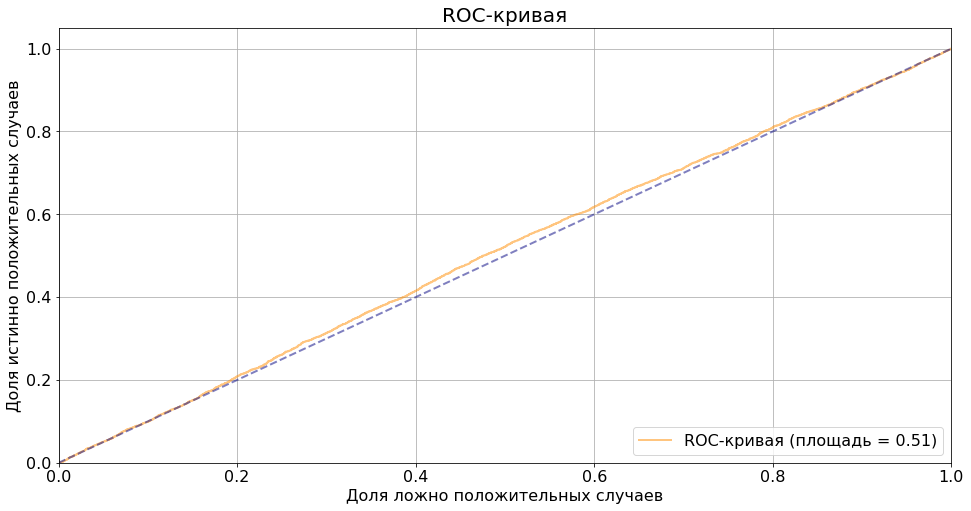

In [118]:
plt.figure(figsize=(16, 8))
lw=2
plt.plot (fpr, tpr, color='darkorange',
         lw=lw, label='ROC-кривая (площадь = %0.2f)' % roc_auc, alpha=0.5)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--', alpha=0.5)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid(True)
plt.xlabel('Доля ложно положительных случаев', fontsize=16)
plt.ylabel('Доля истинно положительных случаев', fontsize=16)
plt.title('ROC-кривая', fontsize=20)
plt.legend(loc='lower right', fontsize=16)
plt.show()

In [119]:
m_param = model.get_feature_importance(train_pool,
                            fstr_type='PredictionValuesChange',
                            prettified=True)

In [71]:
type(m_param)

pandas.core.frame.DataFrame

In [73]:
m_param.to_csv('/home/sash/Python/projects/mlfin/data/model_param.csv')

In [120]:
m_param

,Feature Id,Importances
0,vl_oc_lag_56,1.700061
1,vl_oc_lag_119,1.349321
2,vl_oc_lag_122,1.224091
3,vl_oc_lag_7,1.196007
4,vl_oc_lag_151,1.190394
...,...,...
840,vol_lag_52,0.000000
841,vol_lag_53,0.000000
842,vol_lag_70,0.000000
843,vol_lag_99,0.000000
